In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from imm import *
from simple_kalman import *
from bayes import *

2024-08-27 17:00:39.019338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 17:00:39.856509: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load dataset
ds_2d = load_dataset("/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_aug", batch_size=32, pos_dim=2)
ds_3d = load_dataset("/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_aug", batch_size=32, pos_dim=3)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


2024-08-27 17:00:41.882967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-27 17:00:41.906507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-27 17:00:41.907105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-27 17:00:41.910162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-27 17:00:41.910681: I tensorflow/compile

In [3]:
model = IMM_CVCT_2D(pos_dim=2)

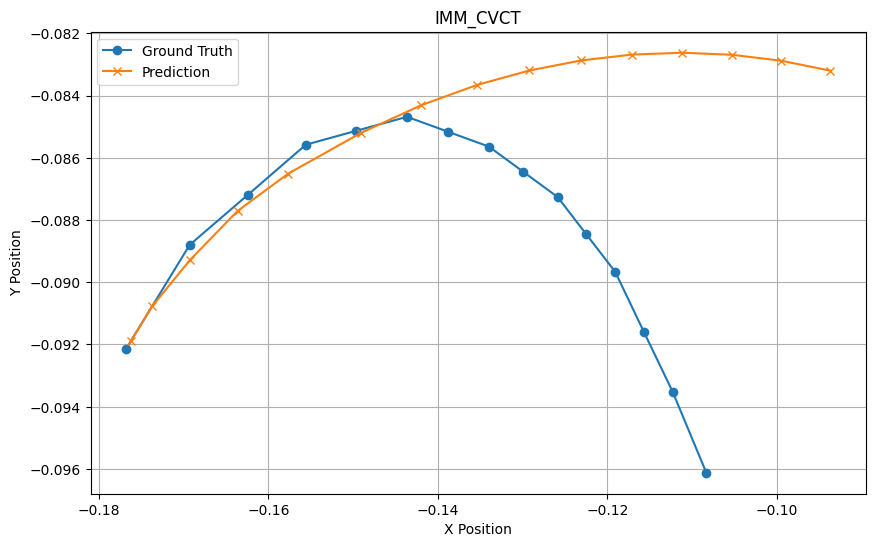

In [10]:
index =1
model.params = {'q': 1.0, 'r': 0.1, 'P':0.1, 
                       'M': [[0.8, 0.2],  # High likelihood of staying in CV
                             [0.2, 0.8]], 
                       'dt': 0.8, 
                       'omega_variance': 1.0}
predictions = model.predict(ds_2d[0][index:])
model.plot_predictions(ds_2d[0][index:], predictions, sample_index=0)

In [75]:
def calculate_meanADE(ground_truth, predictions, dim):
        predicted_positions = predictions[:, :, :dim]
        displacement_errors = np.linalg.norm(ground_truth - predicted_positions, axis=2)
        ADE = np.mean(np.mean(displacement_errors, axis=1))
        return ADE

def calculate_meanFDE(ground_truth, predictions, dim):
        predicted_positions = predictions[:, :, :dim]
        final_displacement_errors = np.linalg.norm(ground_truth[:, -1] - predicted_positions[:, -1], axis=1)
        FDE = np.mean(final_displacement_errors)
        return FDE

In [17]:
from sklearn.model_selection import ParameterGrid

# Updated error calculation function to compare only positions
def calculate_meanADE(ground_truth, predictions, dim):
    predicted_positions = predictions[:, :, :dim]
    displacement_errors = np.linalg.norm(ground_truth - predicted_positions, axis=2)
    ADE = np.mean(np.mean(displacement_errors, axis=1))
    return ADE

# Define the parameter grid
param_grid = {
    'q': [0.1, 0.2, 0.5, 0.8, 1.0], 
     'r': [0.1, 0.2, 0.5, 0.8, 1.0], 
     'P':[0.1, 0.5, 1.0, 10.0], 
    'M': [[[0.9, 0.1],[0.1, 0.9]],
          [[0.8, 0.2],[0.2, 0.8]],
          [[0.6, 0.4],[0.4, 0.6]],
          [[0.5, 0.5],[0.5, 0.5]]
                         ], 
    'dt':  [0.1,0.4,0.9], 
    'omega_variance':[0.1, 0.2, 0.5, 0.8, 1.0]

}

# Generate combinations of parameters
grid = ParameterGrid(param_grid)

best_score = float('inf')
best_params = None

# Grid search loop
for params in grid:
    # Initialize the IMMParticleFilter with current parameters
    model = IMM_CVCT_2D(pos_dim=2)
    model.params['q'] = params['q']
    model.params['r'] = params['r']
    model.params['P'] = params['P']
    model.params['M'] = params['M']
    model.params['dt'] = params['dt']
    model.params['omega_variance'] = params['omega_variance']
    
    # Run the filter on your data and calculate the prediction error
    predictions = model.predict(ds_2d[1][:])
    
    # Calculate the error using the modified function
    error = calculate_meanADE(ds_2d[1][:], predictions, dim=2)

    # Update the best parameters if the current configuration yields a lower error
    if error < best_score:
        best_score = error
        best_params = params

# Print the best hyperparameters and corresponding score
print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'M': [[0.8, 0.2], [0.2, 0.8]], 'P': 0.1, 'dt': 0.4, 'omega_variance': 1.0, 'q': 1.0, 'r': 0.1}
Best Score: 0.008424381859058607
